In [12]:
%run "/Users/thom/Desktop/DSB/bike_counters_/feature_engineering.ipynb"

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


Note: you may need to restart the kernel to use updated packages.


In [1]:
%run "/Users/valentinhenryleo/Documents/Polytechnique/Python/Python_kaggle/bike_counters_/Feature_engineering/feature_engineering.ipynb"

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

/var/folders/rl/bm5wfk4s06n9k8gfktpvjdhh0000gn/T/ipykernel_39317/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


Note: you may need to restart the kernel to use updated packages.


NameError: name 'data_bike' is not defined

NameError: name 'data_bike' is not defined

In [13]:
import holidays
fr_holidays = holidays.France(years=[2020,2021])

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the Date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
    X['weekend'] = X['weekday'].isin([6,7]).astype(int)
    X['night'] = X['hour'].isin([20, 21, 22, 23, 24, 1, 2, 3, 4, 5, 6]).astype(int)
    X['morning'] = X['hour'].isin([6, 7, 8, 9, 10, 11, 12]).astype(int)
    X['midday'] = X['hour'].isin([12, 13, 14]).astype(int)
    X['evening'] = X['hour'].isin([14, 15, 16, 17, 18, 19, 20]).astype(int)

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [14]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [15]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(data_bike_rid,target)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [16]:
_encode_dates(X_train[["date"]]).columns.tolist()

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


['year',
 'month',
 'day',
 'weekday',
 'hour',
 'bankholidays',
 'weekend',
 'night',
 'morning',
 'midday',
 'evening']

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x15d600a40>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'bankholidays', 'weekend',
                                                   'night', 'morning', 'midday',
                                                   'evening']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [19]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Train set, RMSE=0.80
Valid set, RMSE=0.73


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [20]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations (we transform the logarithmic bike counts back to their original unit):

In [21]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


Text(0, 0.5, 'bike_count')

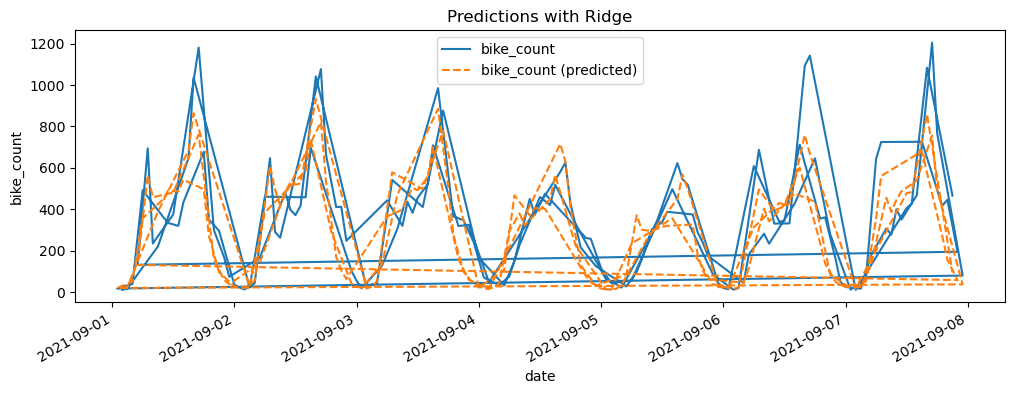

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


<Axes: xlabel='y_true', ylabel='y_pred'>

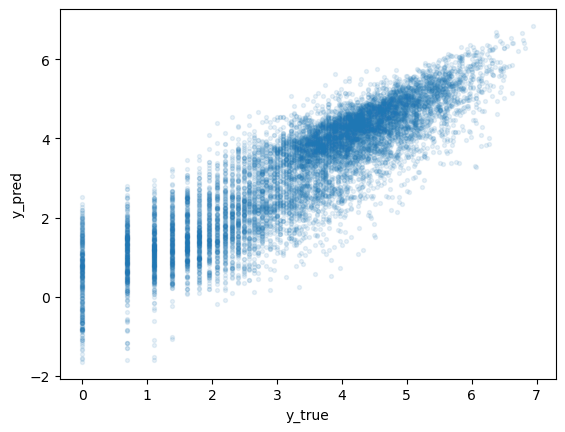

In [23]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({"y_true": y_valid, "y_pred": pipe.predict(X_valid)}).sample(
    10000, random_state=0
)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [24]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)
/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a futu

RMSE:  [-0.82830345 -1.01336016 -0.81990015 -1.08257341 -0.94024976 -1.42123647]
RMSE (all folds): 1.02 ± 0.203


/var/folders/dr/m9v4shms079d9s6z6c8cg57m0000gn/T/ipykernel_71620/2368337008.py:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  X['bankholidays'] = X['date'].isin(fr_holidays).astype(int)


In [25]:
X_valid = pd.read_parquet(Path("data") / "final_test.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [ ]:
y_pred = pipe.predict(X_valid)

results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)
